In [2]:
#Import all the packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings 
warnings.simplefilter(action='ignore',category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action = 'ignore', category = DataConversionWarning)
pd.options.display.max_rows = 10
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#Load a function to be used to visaulize text analysis and NLP coefficients. Courtesy of Michael Parrot of Columiba University
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

# Part 1: Build a classification model using text data

### The data consists of Women’s fashion online shop reviews, consisting of a review Text, and whether the review author would recommend the product.. We are trying to determine whether a reviewer will recommend a product or not based on each review. In a real application this might allow us to find out what is good or bad about certain products or to feature more typical reviews (like a very critical and a very positive one).

# Import the text data

In [4]:
#Assigning the two datasets to data frame objects
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [5]:
#head of review dataframe
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [10]:
Review_train = df[['Review Text','Recommended IND']]
Review_train.columns = Review_train.columns.str.replace(' ','_')

In [11]:
#collumns of dataframe example
Review_train.columns

Index(['Review_Text', 'Recommended_IND'], dtype='object')

In [18]:
Review_train

,Review_Text,Recommended_IND
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1
...,...,...
23481,I was very happy to snag this dress at such a ...,1
23482,"It reminds me of maternity clothes. soft, stre...",1
23483,"This fit well, but the top was very see throug...",0
23484,I bought this dress for a wedding i have this ...,1


# Vectorize the review column into an X matrix



In [30]:
#collumns to be transformed into an x matrix
X = Review_train.Review_Text.values.astype('U')
y = Review_train.Recommended_IND

In [13]:
#importing package and assigning as object to fit to X column to be transformed into a bag of words matrix
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [19]:
#fitting X coumn
X = cv.fit_transform(X.apply(lambda x: np.str_(x)))

In [20]:
#printing matrix as array
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#  Running bag of words, bi grams, and tri grams

In [31]:
#assigning new object of count vectorizer with paramters tuned to elimnated common english stop words as well as only keep words with words atleast 5 letters long. This helps speed up the computation
vectorizer = CountVectorizer(min_df=5, stop_words="english").fit(X)
X = vectorizer.transform(X)

### LOGISTIC REGRESSION Bag of Words

In [33]:
#splitting data into x train, x test, y train, and y test.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
#loading gridsearch cv with kfolds and assigining as objects for ease of use
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5) 
skfold = StratifiedKFold(n_splits=5,shuffle=True)
rkf = RepeatedKFold(n_splits=5, n_repeats=10,random_state=1)

In [35]:
#fitting data to logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, y_train)

C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [36]:
#creating a predictions object for confusion matrix testing before paramter tuning
predictions = logreg.predict(X_test)

In [37]:
#running a grid search cv in logistic C paramater and printing the best paramter
param_grid = {'C': [.00001, .0001, .001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)

C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Best parameters:  {'C': 0.1}


C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
#loading accuracy score of logistic regression
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.88


In [39]:
#running a confusion matrix of the precision and recall of classifcation for logistic model before tuning
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[ 612  452]
 [ 250 4558]]


              precision    recall  f1-score   support

           0       0.71      0.58      0.64      1064
           1       0.91      0.95      0.93      4808

    accuracy                           0.88      5872
   macro avg       0.81      0.76      0.78      5872
weighted avg       0.87      0.88      0.88      5872



In [40]:
#running a confusion matrix of the precision and recall of classifcation for logistic model after tuning
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
predictions = logreg.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[ 550  514]
 [ 185 4623]]


              precision    recall  f1-score   support

           0       0.75      0.52      0.61      1064
           1       0.90      0.96      0.93      4808

    accuracy                           0.88      5872
   macro avg       0.82      0.74      0.77      5872
weighted avg       0.87      0.88      0.87      5872



**Note** after tuning, the precession increases for negative review classification but decreases for positive review classification

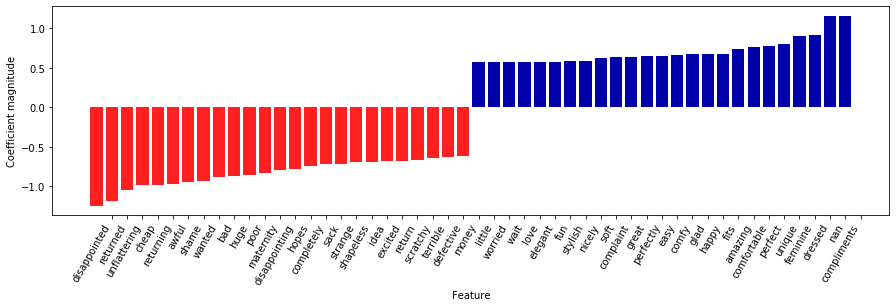

In [42]:
#visualizing coefficients using the above function
coefs = LogisticRegression(C=0.1).fit(X_train,y_train).coef_
feature_names = vectorizer.get_feature_names()


visualize_coefficients(coefs, feature_names, n_top_features=25)

# Bag of Words with bi grams

In [49]:
#loading and fitting bag of words model with bi-grams to review data
from sklearn.feature_extraction.text import TfidfVectorizer
X = Review_train.Review_Text.values.astype('U')
vect = TfidfVectorizer(ngram_range=(1,2) ,min_df=5, norm=None).fit(X)
X = vect.transform(X)
y = Review_train.Recommended_IND

In [50]:
#tuning parameters to select best C paramter for logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(),param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best parameters:\n{}".format(grid.best_params_))

C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Best parameters:
{'C': 0.01}


In [51]:
#running confusion matrix on correct precision and recall of classification
logreg = LogisticRegression(C=0.01).fit(X_train, y_train)
predictions = logreg.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[ 665  399]
 [ 193 4615]]


              precision    recall  f1-score   support

           0       0.78      0.62      0.69      1064
           1       0.92      0.96      0.94      4808

    accuracy                           0.90      5872
   macro avg       0.85      0.79      0.82      5872
weighted avg       0.89      0.90      0.89      5872



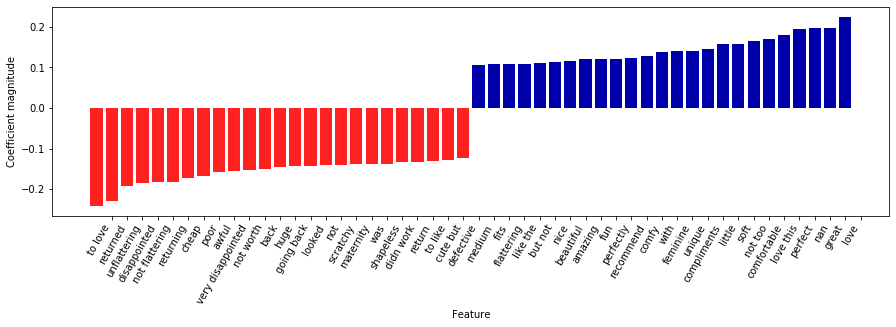

In [52]:
#using visualize coefficients function to see coefficients 
coefs = LogisticRegression(C=0.01).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()


visualize_coefficients(coefs, feature_names, n_top_features=25)

**Note** although the weighted average precision increase, the magnitude of the coefficeints shrinks when we add more grams.  

# Bag of Words with single words, bi grams, and tri grams



In [55]:
#loading and fitting bag of words model with single grams, bi-grams, and tigrams to review data and then rescaling the data with tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
X = Review_train.Review_Text.values.astype('U')
vect = TfidfVectorizer(ngram_range=(1,3) ,min_df=5, norm=None).fit(X)
X = vect.transform(X)
y = Review_train.Recommended_IND

In [56]:
#tuning parameters to select best C paramter for logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(),param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best parameters:\n{}".format(grid.best_params_))

C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Best parameters:
{'C': 100}


C:\Users\zacha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [57]:
#running confusion matrix on correct precision and recall of classification with tuned paramater
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
predictions = logreg.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[ 667  397]
 [ 210 4598]]


              precision    recall  f1-score   support

           0       0.76      0.63      0.69      1064
           1       0.92      0.96      0.94      4808

    accuracy                           0.90      5872
   macro avg       0.84      0.79      0.81      5872
weighted avg       0.89      0.90      0.89      5872



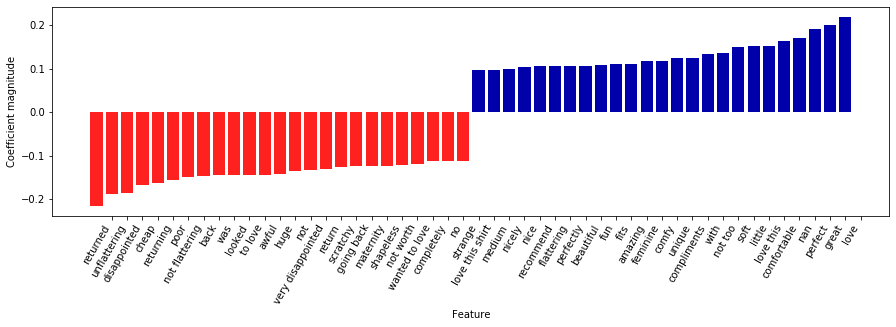

In [58]:
coefs = LogisticRegression(C=0.01).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()


visualize_coefficients(coefs, feature_names, n_top_features=25)